One-paragraph abstract (150 words or less, in a Word file)  
Digital headshot (high-resolution JPG preferred)  
**Letter of tax determination from your institution  
W-9 Form from your institution** 


# Imports

In [1]:
# imports

import os, sys
import numpy as np
import SimpleITK as sitk

from helpers_general import sitk2np, np2sitk, print_sitk_info, round_tuple, lrange, get_roi_range, numbers2groups
from helpers_preprocess import mask2bbox, print_bbox, get_bbox_size, print_bbox_size, get_data_dict, folder2objs
from helpers_metrics import compute_dice_coefficient, compute_coverage_coefficient
from helpers_viz import viz_axis

In [2]:
# auto-reload when local helper fns change
%load_ext autoreload
%autoreload 2

%matplotlib inline

# Load Data

In [3]:
# Data path

PROJ_PATH = "."

# Folders containing MR train data
train_path = f"{PROJ_PATH}/train_data/train_data"
train_data_dict = get_data_dict(train_path)

# print train data dict
print(f"Train data folders: {numbers2groups(sorted([int(x) for x in os.listdir(train_path)]))}")
print(f"Training data: key = train folder, value = full path to (segm obj, nii file)\n")

# Load atlas: atlas MRs (10 MRs labelled by Dr. Hollon, need nii LPS=>RAS adjustment)

atlas_range, ras_adj = [50460], True
atlas_folders = [str(i) for i in atlas_range]
atlas_objs, atlas_mask_objs = zip(*[folder2objs(atlas_folder, train_data_dict, ras_adj) \
                               for atlas_folder in atlas_folders])

# Load input: set input MRs (Samir's, no RAS adj needed for mask)

input_range, ras_adj = [50012], False
input_folders = [str(i) for i in input_range]
input_objs, input_mask_objs = zip(*[folder2objs(input_folder, train_data_dict, ras_adj) \
                               for input_folder in input_folders])

Train data folders: [range(50002, 50017), range(50019, 50020), range(50022, 50049), range(50455, 50464)]
Training data: key = train folder, value = full path to (segm obj, nii file)



### Compare metadata

In [4]:
atlas_obj, atlas_mask_obj = atlas_objs[0], atlas_mask_objs[0]
input_obj, input_mask_obj = input_objs[0], input_mask_objs[0]

def lmap(fn, arr): return [fn(o) for o in arr]

atlas_arr, atlas_mask_arr, input_arr, input_mask_arr = lmap(sitk2np, (atlas_obj, atlas_mask_obj, input_obj, input_mask_obj))
atlas_bbox_coords, input_bbox_coords = lmap(mask2bbox, (atlas_mask_arr, input_mask_arr))

print("Atlas"); print_bbox(*atlas_bbox_coords); print();
print("Input"); print_bbox(*input_bbox_coords); print();

# Print metadata
print("Input MR"); print_sitk_info(input_obj), print();
print("Atlas MR"); print_sitk_info(atlas_obj); print();

Atlas
Bbox coords: (68, 239, 221) to (92, 294, 251). Size: 24, 55, 30.
Bounding box coord: from location (239, 221) of slice 68 to location (294, 251) of slice 92.

Input
Bbox coords: (75, 118, 119) to (97, 139, 139). Size: 22, 21, 20.
Bounding box coord: from location (118, 119) of slice 75 to location (139, 139) of slice 97.

Input MR
Size:  (176, 256, 256)
Origin:  (-87.51664733886719, 132.53253173828125, -127.22270202636719)
Spacing:  (1.0500000715255737, 1.05078125, 1.05078125)
Direction:  (1.0, 0.0, 0.0, 0.0, -1.0, 0.0, 0.0, 0.0, 1.0)
Pixel type: 2 = 16-bit signed integer

Atlas MR
Size:  (160, 480, 512)
Origin:  (-95.70238494873047, 77.71624755859375, -118.06993103027344)
Spacing:  (1.2000000476837158, 0.5, 0.5)
Direction:  (1.0, 0.0, 0.0, 0.0, -1.0, 0.0, 0.0, 0.0, 1.0)
Pixel type: 2 = 16-bit signed integer



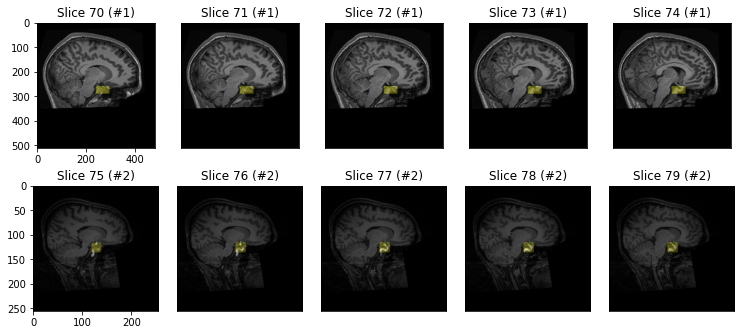

In [5]:
# Viz
atlas_slice_range = lrange(70,75)
input_slice_range = lrange(75, 80)

viz_axis(np_arr = atlas_arr, \
        bin_mask_arr  = atlas_mask_arr, color1 = "yellow", alpha1=0.3, \
        slices=atlas_slice_range, fixed_axis=0, \
        axis_fn = np.rot90, \
         
        np_arr_b = input_arr, \
        bin_mask_arr_b  = input_mask_arr, color1_b = "yellow", alpha1_b=0.3, \
        slices_b = input_slice_range, fixed_axis_b=0, \
        axis_fn_b = np.rot90, \
         
        grid = [2, 5], hspace=0.3, fig_mult=2)

In [6]:
# Crop https://github.com/SimpleITK/ISBI2018_TUTORIAL/blob/master/python/03_data_augmentation.ipynb

In [7]:
def threshold_based_crop(image, mask):
    '''
    Use Otsu's threshold estimator to separate background and foreground. In medical imaging the background is
    usually air. Then crop the image using the foreground's axis aligned bounding box.
    Args:
        image (SimpleITK image): An image where the anatomy and background intensities form a bi-modal distribution
                                 (the assumption underlying Otsu's method.)
    Return:
        Cropped image based on foreground's axis aligned bounding box.  
    '''
    # Set pixels that are in [min_intensity,otsu_threshold] to inside_value, values above otsu_threshold are
    # set to outside_value. The anatomy has higher intensity values than the background, so it is outside.
    inside_value = 0
    outside_value = 255
    label_shape_filter = sitk.LabelShapeStatisticsImageFilter()
    label_shape_filter.Execute( sitk.OtsuThreshold(image, inside_value, outside_value) )
    bounding_box = label_shape_filter.GetBoundingBox(outside_value)
    # The bounding box's first "dim" entries are the starting index and last "dim" entries the size
    return (sitk.RegionOfInterest(image, bounding_box[int(len(bounding_box)/2):], bounding_box[0:int(len(bounding_box)/2)]), \
            sitk.RegionOfInterest(mask, bounding_box[int(len(bounding_box)/2):], bounding_box[0:int(len(bounding_box)/2)]))

In [8]:
cropped_atlas_obj, cropped_atlas_mask_obj = threshold_based_crop(atlas_obj, atlas_mask_obj)
cropped_input_obj, cropped_input_mask_obj = threshold_based_crop(input_obj, input_mask_obj)

In [9]:
cropped_atlas_arr, cropped_atlas_mask_arr, cropped_input_arr, cropped_input_mask_arr = \
    lmap(sitk2np, (cropped_atlas_obj, cropped_atlas_mask_obj, cropped_input_obj, cropped_input_mask_obj))

cropped_atlas_bbox_coords, cropped_input_bbox_coords = lmap(mask2bbox, (cropped_atlas_mask_arr, cropped_input_mask_arr))

print("Atlas"); print_bbox(*atlas_bbox_coords); print();
print("Cropped Atlas"); print_bbox(*cropped_atlas_bbox_coords); print();

print("Input"); print_bbox(*input_bbox_coords); print();
print("Cropped Input"); print_bbox(*cropped_input_bbox_coords); print();

# Print metadata
# print("Input MR"); print_sitk_info(input_obj), print();
# print("Cropped Input MR"); print_sitk_info(cropped_input_obj), print();

# print("Atlas MR"); print_sitk_info(atlas_obj); print();
# print("Cropped Atlas MR"); print_sitk_info(cropped_atlas_obj); print();

Atlas
Bbox coords: (68, 239, 221) to (92, 294, 251). Size: 24, 55, 30.
Bounding box coord: from location (239, 221) of slice 68 to location (294, 251) of slice 92.

Cropped Atlas
Bbox coords: (61, 219, 61) to (85, 274, 91). Size: 24, 55, 30.
Bounding box coord: from location (219, 61) of slice 61 to location (274, 91) of slice 85.

Input
Bbox coords: (75, 118, 119) to (97, 139, 139). Size: 22, 21, 20.
Bounding box coord: from location (118, 119) of slice 75 to location (139, 139) of slice 97.

Cropped Input
Bbox coords: (65, 117, 80) to (87, 138, 100). Size: 22, 21, 20.
Bounding box coord: from location (117, 80) of slice 65 to location (138, 100) of slice 87.



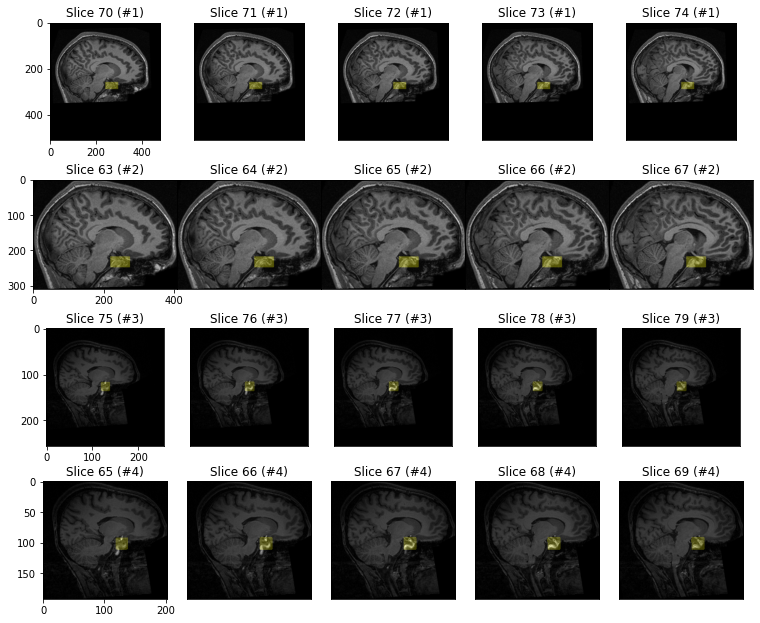

In [10]:
# Viz
atlas_slice_range        = lrange(70,75)
cropped_atlas_slice_range = lrange(63, 68)

input_slice_range        = lrange(75,80)
cropped_input_slice_range = lrange(65, 70)

viz_axis(np_arr = atlas_arr, \
        bin_mask_arr  = atlas_mask_arr, color1 = "yellow", alpha1=0.3, \
        slices=atlas_slice_range, fixed_axis=0, \
        axis_fn = np.rot90, \
         
        np_arr_b = cropped_atlas_arr, \
        bin_mask_arr_b  = cropped_atlas_mask_arr,
        slices_b = cropped_atlas_slice_range, \
         
        np_arr_c = input_arr, \
        bin_mask_arr_c  = input_mask_arr,
        slices_c = input_slice_range, \
         
        np_arr_d = cropped_input_arr, \
        bin_mask_arr_d  = cropped_input_mask_arr,
        slices_d = cropped_input_slice_range, \
         
        grid = [4, 5], hspace=0.3, fig_mult=2)

In [11]:
print("Cropped Atlas", cropped_atlas_obj.GetSize(), "Original", atlas_obj.GetSize())
print("Cropped Input", cropped_input_obj.GetSize(), "Original", input_obj.GetSize())

Cropped Atlas (145, 408, 310) Original (160, 480, 512)
Cropped Input (152, 203, 192) Original (176, 256, 256)


### Resample to Standard Reference Domain

In [12]:
# src: https://github.com/SimpleITK/ISBI2018_TUTORIAL/blob/master/python/03_data_augmentation.ipynb

dimension = 3 # 3D MRs
pixel_id = 2 # 16-bit signed integer

# Physical image size corresponds to the largest physical size in the training set, or any other arbitrary size.
reference_physical_size = np.zeros(dimension)

img_data = [(o.GetSize(), o.GetSpacing()) for o in (cropped_atlas_obj, cropped_input_obj)]
for img_sz, img_spc in img_data:
    reference_physical_size[:] = [(sz-1)*spc if sz*spc>mx else mx \
                                  for sz, spc, mx in zip(img_sz, img_spc, reference_physical_size)]
    
# Create the reference image with a zero origin, identity direction cosine matrix and dimension     
reference_origin = np.zeros(dimension)
reference_direction = np.identity(dimension).flatten()


# Isotropic (1,1,1) pixels
reference_spacing = np.ones(dimension)
reference_size = [int(phys_sz/(spc) + 1) for phys_sz,spc in zip(reference_physical_size, reference_spacing)]

# Set reference image attributes
reference_image = sitk.Image(reference_size, pixel_id)
reference_image.SetOrigin(reference_origin)
reference_image.SetSpacing(reference_spacing)
reference_image.SetDirection(reference_direction)

reference_center = np.array(reference_image.TransformContinuousIndexToPhysicalPoint(np.array(reference_image.GetSize())/2.0))

In [13]:
def resample(img, mask, interpolator = sitk.sitkLinear, default_intensity_value = 0.0):
    
    # Define translation transform mapping origins from reference_image to the current img
    transform = sitk.AffineTransform(dimension)
    transform.SetMatrix(img.GetDirection())
    transform.SetTranslation(np.array(img.GetOrigin()) - reference_origin)
    
    # Modify the transformation to align the centers of the original and reference image instead of their origins.
    centering_transform = sitk.TranslationTransform(dimension)
    img_center = np.array(img.TransformContinuousIndexToPhysicalPoint(np.array(img.GetSize())/2.0))
    centering_transform.SetOffset(np.array(transform.GetInverse().TransformPoint(img_center) - reference_center))
    centered_transform = sitk.Transform(transform)
    centered_transform.AddTransform(centering_transform)
    
    return sitk.Resample(img, reference_image, centered_transform, interpolator, default_intensity_value), \
            sitk.Resample(mask, reference_image, centered_transform, sitk.sitkNearestNeighbor, default_intensity_value)

In [14]:
resampled_atlas_obj, resampled_atlas_mask_obj = resample(cropped_atlas_obj, cropped_atlas_mask_obj)
resampled_input_obj, resampled_input_mask_obj = resample(cropped_input_obj, cropped_input_mask_obj)

In [15]:
resampled_atlas_arr, resampled_atlas_mask_arr, resampled_input_arr, resampled_input_mask_arr = \
    lmap(sitk2np, (resampled_atlas_obj, resampled_atlas_mask_obj, resampled_input_obj, resampled_input_mask_obj))

resampled_atlas_bbox_coords, resampled_input_bbox_coords = lmap(mask2bbox, (resampled_atlas_mask_arr, resampled_input_mask_arr))

print("Resampled Atlas"); print_bbox(*resampled_atlas_bbox_coords); print();
print("Cropped Atlas"); print_bbox(*cropped_atlas_bbox_coords); print();

print("Resampled Input"); print_bbox(*resampled_input_bbox_coords); print();
print("Cropped Input"); print_bbox(*cropped_input_bbox_coords); print();

Resampled Atlas
Bbox coords: (73, 114, 54) to (102, 141, 68). Size: 29, 27, 14.
Bounding box coord: from location (114, 54) of slice 73 to location (141, 68) of slice 102.

Cropped Atlas
Bbox coords: (61, 219, 61) to (85, 274, 91). Size: 24, 55, 30.
Bounding box coord: from location (219, 61) of slice 61 to location (274, 91) of slice 85.

Resampled Input
Bbox coords: (75, 123, 84) to (98, 145, 105). Size: 23, 22, 21.
Bounding box coord: from location (123, 84) of slice 75 to location (145, 105) of slice 98.

Cropped Input
Bbox coords: (65, 117, 80) to (87, 138, 100). Size: 22, 21, 20.
Bounding box coord: from location (117, 80) of slice 65 to location (138, 100) of slice 87.



In [16]:
# Print metadata
print("Resampled Input MR"); print_sitk_info(resampled_input_obj), print();
print("Cropped Input MR"); print_sitk_info(cropped_input_obj), print();

print("Resampled Atlas MR"); print_sitk_info(resampled_atlas_obj); print();
print("Cropped Atlas MR"); print_sitk_info(cropped_atlas_obj); print();

Resampled Input MR
Size:  (173, 213, 201)
Origin:  (0.0, 0.0, 0.0)
Spacing:  (1.0, 1.0, 1.0)
Direction:  (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
Pixel type: 2 = 16-bit signed integer

Cropped Input MR
Size:  (152, 203, 192)
Origin:  (-77.01664662361145, 131.48175048828125, -86.24223327636719)
Spacing:  (1.0500000715255737, 1.05078125, 1.05078125)
Direction:  (1.0, 0.0, 0.0, 0.0, -1.0, 0.0, 0.0, 0.0, 1.0)
Pixel type: 2 = 16-bit signed integer

Resampled Atlas MR
Size:  (173, 213, 201)
Origin:  (0.0, 0.0, 0.0)
Spacing:  (1.0, 1.0, 1.0)
Direction:  (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
Pixel type: 2 = 16-bit signed integer

Cropped Atlas MR
Size:  (145, 408, 310)
Origin:  (-87.30238461494446, 67.71624755859375, -38.06993103027344)
Spacing:  (1.2000000476837158, 0.5, 0.5)
Direction:  (1.0, 0.0, 0.0, 0.0, -1.0, 0.0, 0.0, 0.0, 1.0)
Pixel type: 2 = 16-bit signed integer



In [17]:
for arr in resampled_atlas_arr, resampled_atlas_mask_arr, resampled_input_arr, resampled_input_mask_arr:
    print(arr.shape)

(173, 213, 201)
(173, 213, 201)
(173, 213, 201)
(173, 213, 201)


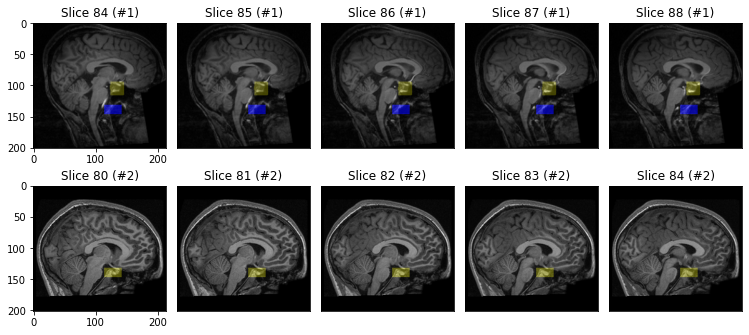

In [18]:
# Viz
resampled_atlas_slice_range = lrange(80,85)
resampled_input_slice_range = lrange(84, 89)

viz_axis(np_arr = resampled_input_arr, \
        bin_mask_arr  = resampled_input_mask_arr, color1 = "yellow", alpha1=0.3, \
        bin_mask_arr2  = resampled_atlas_mask_arr, color2 = "blue", alpha2=0.7, \
        slices=resampled_input_slice_range, fixed_axis=0, \
        axis_fn = np.rot90, \
         
        np_arr_b = resampled_atlas_arr, \
        bin_mask_arr_b  = resampled_atlas_mask_arr, color1_b = "yellow", alpha1_b=0.3, \
        slices_b = resampled_atlas_slice_range, fixed_axis_b=0, \
        axis_fn_b = np.rot90, \
         
        grid = [2, 5], hspace=0.3, fig_mult=2)

Original dice

In [19]:
orig_dice = compute_dice_coefficient(resampled_input_mask_arr, resampled_atlas_mask_arr)
print(f"Unaligned dice: {orig_dice:.3f}")

Unaligned dice: 0.000


### Align

In [20]:
# set moving and fixed images (resample moving=>fixed using T:fixed=>moving)
fixed_obj = resampled_input_obj
moving_obj = resampled_atlas_obj

In [21]:
elastixImageFilter = sitk.ElastixImageFilter()
elastixImageFilter.SetFixedImage(fixed_obj)
elastixImageFilter.SetMovingImage(moving_obj)

# set parameter map
param_folder = "ElastixParamFiles"
param_files = ["affine.txt"]

parameterMapVector = sitk.VectorOfParameterMap()
for param_file in param_files:
    parameterMapVector.append(sitk.ReadParameterFile(f"{param_folder}/{param_file}"))
elastixImageFilter.SetParameterMap(parameterMapVector)

# Execute alignment
#elastixImageFilter.SetLogToConsole(False)
elastixImageFilter.Execute()

pred_obj = elastixImageFilter.GetResultImage()

# MAP MOVING (ATLAS BINARY ROI) ONTO FIXED (INPUT) 

# set moving image (atlas)                                                    
transformixImageFilter = sitk.TransformixImageFilter()
transformixImageFilter.SetMovingImage(resampled_atlas_mask_obj)

# set parameter map (Binary mask => nearest neighbor final interpolation)
transformedParameterMapVector = elastixImageFilter.GetTransformParameterMap()
transformedParameterMapVector[-1]["ResampleInterpolator"] = ["FinalNearestNeighborInterpolator"]
transformixImageFilter.SetTransformParameterMap(transformedParameterMapVector)

# Execute transformation
transformixImageFilter.Execute()

pred_mask_obj = transformixImageFilter.GetResultImage()

In [22]:
print("Input"), print_sitk_info(resampled_input_obj)
print("Atlas"), print_sitk_info(resampled_atlas_obj)
print("Pred"), print_sitk_info(pred_obj)
print("Mask"), print_sitk_info(pred_mask_obj)

Input
Size:  (173, 213, 201)
Origin:  (0.0, 0.0, 0.0)
Spacing:  (1.0, 1.0, 1.0)
Direction:  (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
Pixel type: 2 = 16-bit signed integer
Atlas
Size:  (173, 213, 201)
Origin:  (0.0, 0.0, 0.0)
Spacing:  (1.0, 1.0, 1.0)
Direction:  (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
Pixel type: 2 = 16-bit signed integer
Pred
Size:  (173, 213, 201)
Origin:  (0.0, 0.0, 0.0)
Spacing:  (1.0, 1.0, 1.0)
Direction:  (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
Pixel type: 8 = 32-bit float
Mask
Size:  (173, 213, 201)
Origin:  (0.0, 0.0, 0.0)
Spacing:  (1.0, 1.0, 1.0)
Direction:  (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
Pixel type: 8 = 32-bit float


(None, None)

In [23]:
pred_mask_arr = sitk2np(pred_mask_obj)
pred_bbox_coords = mask2bbox(pred_mask_arr)

print("Prediction: Atlas Aligned Bbox"); print_bbox(*pred_bbox_coords); print();
print("Ground Truth: Input Bbox"); print_bbox(*resampled_input_bbox_coords); print();

Prediction: Atlas Aligned Bbox
Bbox coords: (73, 124, 63) to (99, 149, 81). Size: 26, 25, 18.
Bounding box coord: from location (124, 63) of slice 73 to location (149, 81) of slice 99.

Ground Truth: Input Bbox
Bbox coords: (75, 123, 84) to (98, 145, 105). Size: 23, 22, 21.
Bounding box coord: from location (123, 84) of slice 75 to location (145, 105) of slice 98.



In [24]:
pred_dice = compute_dice_coefficient(sitk2np(pred_mask_obj).astype(bool), resampled_input_mask_arr.astype(bool))
print(f"Pred dice: {pred_dice:.3f}")

Pred dice: 0.000


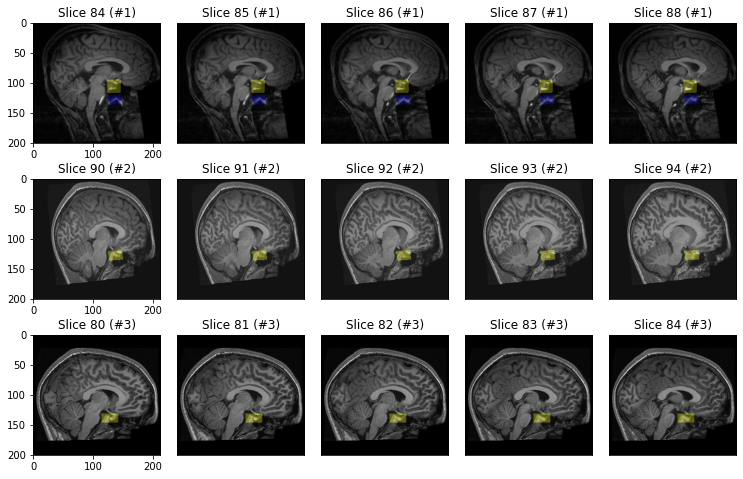

In [25]:
# Viz
pred_slice_range = lrange(90,95)
resampled_input_slice_range = lrange(84, 89)

# Row 1. Input w/ GT and Pred
# Row 2. Mapped Atlas w/ mapped atlas ROI
# Row 3. Atlas w/ Atlas ROI

viz_axis(np_arr = resampled_input_arr, \
        bin_mask_arr  = resampled_input_mask_arr, color1 = "yellow", alpha1=0.3, \
        bin_mask_arr2  = pred_mask_arr, color2 = "blue", alpha2=0.3, \
        slices=resampled_input_slice_range, fixed_axis=0, \
        axis_fn = np.rot90, \
         
        np_arr_b = sitk2np(pred_obj), \
        bin_mask_arr_b  = pred_mask_arr, color1_b = "yellow", alpha1_b=0.3,
        slices_b = pred_slice_range,
         
        np_arr_c = resampled_atlas_arr, \
        bin_mask_arr_c  = resampled_atlas_mask_arr, color1_c = "yellow", alpha1_c=0.3,
        slices_c = resampled_atlas_slice_range,
         
        grid = [3, 5], hspace=0.3, fig_mult=2)

In [26]:
# viz alignment
def get_composite(a, b):
    a = sitk.Cast(a, sitk.sitkUInt8)
    b = sitk.Cast(b, sitk.sitkUInt8)
    return sitk2np(sitk.Cast(sitk.Compose(a, 0.5*a + 0.5*b, b), sitk.sitkVectorUInt8))

In [27]:
# corig  = get_composite(resampled_input_obj, resampled_atlas_obj)
# calign = get_composite(resampled_input_obj, pred_obj)

In [28]:
# # Viz
# resampled_input_slice_range = lrange(84, 89)

# # Row 1. Composite: Input + Atlas
# # Row 2. Composite: Input + Aligned Atlas

# viz_axis(np_arr = corig, \
#         slices=resampled_input_slice_range, fixed_axis=0, \
#         axis_fn = np.rot90, \
         
#         np_arr_b = calign, \
         
#         grid = [2, 5], hspace=0.3, fig_mult=2)

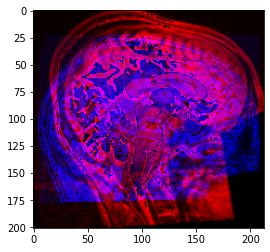

In [29]:
import matplotlib.pyplot as plt

simg1 = resampled_input_obj
simg2 = resampled_atlas_obj
cimg = sitk.Cast(sitk.Compose(simg1, 0.5*simg1 + 0.5*simg2, simg2), \
                 sitk.sitkVectorUInt8)
carr = sitk2np(cimg)
plt.imshow(np.rot90(carr[85,:,:,:]))

In [30]:
# plt.imshow(np.rot90(corig[85,:,:,:]))

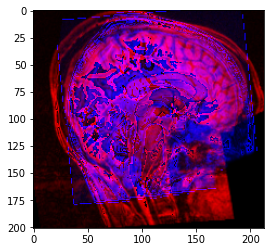

In [31]:
# viz alignment

simg1 = resampled_input_obj
simg2 = sitk.Cast(pred_obj, sitk.sitkInt16)

cimg = sitk.Cast(sitk.Compose(simg1, 0.5*simg1 + 0.5*simg2, simg2), \
                 sitk.sitkVectorUInt8)
carr = sitk2np(cimg)
plt.imshow(np.rot90(carr[85,:,:,:]))


### Cascaded ALign

In [32]:
print("Prediction: Atlas Aligned Bbox"); print_bbox(*pred_bbox_coords); print();
print("Ground Truth: Input Bbox"); print_bbox(*resampled_input_bbox_coords); print();

Prediction: Atlas Aligned Bbox
Bbox coords: (73, 124, 63) to (99, 149, 81). Size: 26, 25, 18.
Bounding box coord: from location (124, 63) of slice 73 to location (149, 81) of slice 99.

Ground Truth: Input Bbox
Bbox coords: (75, 123, 84) to (98, 145, 105). Size: 23, 22, 21.
Bounding box coord: from location (123, 84) of slice 75 to location (145, 105) of slice 98.



In [33]:
print(pred_bbox_coords);
print(resampled_input_bbox_coords)

(73, 99, 124, 149, 63, 81)
(75, 98, 123, 145, 84, 105)


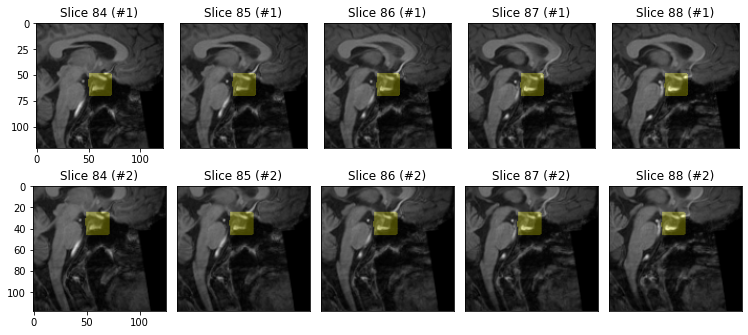

In [34]:
# viz cropping 50 vox around bounding box
viz_axis(np_arr = resampled_input_arr, cmap0="gray",
        crop_coords = resampled_input_bbox_coords, crop_extra=50,
        bin_mask_arr = resampled_input_mask_arr, color1 = "yellow", alpha1=0.3,
        slices=resampled_input_slice_range, fixed_axis=0, \
        axis_fn = np.rot90, \
         
        np_arr_b = resampled_input_arr,
        crop_coords_b = pred_bbox_coords, crop_extra_b=50,
        bin_mask_arr_b = resampled_input_mask_arr,
        slices_b=resampled_input_slice_range,
         
        grid = [2, 5], hspace=0.3, fig_mult=2)

In [35]:
def get_cropped(pads, bbox_coords, obj, mask_obj):
    ipad, jpad, kpad = pads
    imin, imax, jmin, jmax, kmin, kmax = bbox_coords
    return      obj[imin-ipad:imin+ipad, jmin-jpad:jmin+jpad, kmin-kpad:kmin+kpad], \
           mask_obj[imin-ipad:imin+ipad, jmin-jpad:jmin+jpad, kmin-kpad:kmin+kpad]

In [36]:
pads = 50,50,50

# Align Atlas ROI + pad w/ Pred ROI + pad
cascade_atlas_obj, cascade_atlas_mask_obj = get_cropped(pads, resampled_atlas_bbox_coords, resampled_atlas_obj, resampled_atlas_mask_obj)
cascade_input_obj, cascade_input_mask_obj = get_cropped(pads, pred_bbox_coords,  resampled_input_obj, resampled_input_mask_obj)

cascade_atlas_arr, cascade_atlas_mask_arr, cascade_input_arr, cascade_input_mask_arr = \
    lmap(sitk2np, (cascade_atlas_obj, cascade_atlas_mask_obj, cascade_input_obj, cascade_input_mask_obj))

cascade_atlas_bbox_coords, cascade_input_bbox_coords = lmap(mask2bbox, (cascade_atlas_mask_arr, cascade_input_mask_arr))

In [37]:
# Print metadata
print("Resampled Input MR"); print_sitk_info(resampled_input_obj), print();
print("Cropped Input MR"); print_sitk_info(cascade_input_obj), print();

print("Resampled Atlas MR"); print_sitk_info(resampled_atlas_obj); print();
print("Cropped Atlas MR"); print_sitk_info(cascade_atlas_obj); print();

Resampled Input MR
Size:  (173, 213, 201)
Origin:  (0.0, 0.0, 0.0)
Spacing:  (1.0, 1.0, 1.0)
Direction:  (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
Pixel type: 2 = 16-bit signed integer

Cropped Input MR
Size:  (100, 100, 100)
Origin:  (23.0, 74.0, 13.0)
Spacing:  (1.0, 1.0, 1.0)
Direction:  (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
Pixel type: 2 = 16-bit signed integer

Resampled Atlas MR
Size:  (173, 213, 201)
Origin:  (0.0, 0.0, 0.0)
Spacing:  (1.0, 1.0, 1.0)
Direction:  (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
Pixel type: 2 = 16-bit signed integer

Cropped Atlas MR
Size:  (100, 100, 100)
Origin:  (23.0, 64.0, 4.0)
Spacing:  (1.0, 1.0, 1.0)
Direction:  (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
Pixel type: 2 = 16-bit signed integer



In [38]:
print("Resampled Atlas"); print_bbox(*resampled_atlas_bbox_coords); print();
print("Cropped Atlas"); print_bbox(*cascade_atlas_bbox_coords); print();

print("Resampled Input"); print_bbox(*resampled_input_bbox_coords); print();
print("Cropped Input"); print_bbox(*cascade_input_bbox_coords); print();

Resampled Atlas
Bbox coords: (73, 114, 54) to (102, 141, 68). Size: 29, 27, 14.
Bounding box coord: from location (114, 54) of slice 73 to location (141, 68) of slice 102.

Cropped Atlas
Bbox coords: (50, 50, 50) to (79, 77, 64). Size: 29, 27, 14.
Bounding box coord: from location (50, 50) of slice 50 to location (77, 64) of slice 79.

Resampled Input
Bbox coords: (75, 123, 84) to (98, 145, 105). Size: 23, 22, 21.
Bounding box coord: from location (123, 84) of slice 75 to location (145, 105) of slice 98.

Cropped Input
Bbox coords: (52, 49, 71) to (75, 71, 92). Size: 23, 22, 21.
Bounding box coord: from location (49, 71) of slice 52 to location (71, 92) of slice 75.



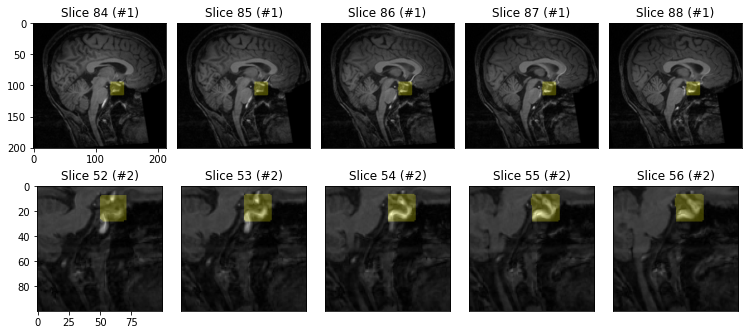

In [39]:
# viz cropping 50 vox around bounding box
cascade_input_slice_range = lrange(52,57)

viz_axis(np_arr = resampled_input_arr, cmap0="gray",
        bin_mask_arr = resampled_input_mask_arr, color1 = "yellow", alpha1=0.3,
        slices=resampled_input_slice_range, fixed_axis=0, \
        axis_fn = np.rot90, \
         
        np_arr_b = cascade_input_arr,
        bin_mask_arr_b = cascade_input_mask_arr,
        slices_b=cascade_input_slice_range,
         
        grid = [2, 5], hspace=0.3, fig_mult=2)

#### Aligm

In [40]:
# set moving and fixed images (resample moving=>fixed using T:fixed=>moving)
fixed_obj, fixed_mask_obj   = cascade_input_obj, cascade_input_mask_obj
moving_obj, moving_mask_obj = cascade_atlas_obj, cascade_atlas_mask_obj

In [41]:
elastixImageFilter = sitk.ElastixImageFilter()
elastixImageFilter.SetFixedImage(fixed_obj)
elastixImageFilter.SetMovingImage(moving_obj)

# set parameter map
param_folder = "ElastixParamFiles"
param_files = ["affine.txt"]

parameterMapVector = sitk.VectorOfParameterMap()
for param_file in param_files:
    parameterMapVector.append(sitk.ReadParameterFile(f"{param_folder}/{param_file}"))
elastixImageFilter.SetParameterMap(parameterMapVector)

# Execute alignment
#elastixImageFilter.SetLogToConsole(False)
elastixImageFilter.Execute()

# IMPORTANT OUTPUT 1
cascade_pred_obj = elastixImageFilter.GetResultImage()

# MAP MOVING (ATLAS BINARY ROI) ONTO FIXED (INPUT) 

# set moving image (atlas)                                                    
transformixImageFilter = sitk.TransformixImageFilter()
transformixImageFilter.SetMovingImage(moving_mask_obj)

# set parameter map (Binary mask => nearest neighbor final interpolation)
transformedParameterMapVector = elastixImageFilter.GetTransformParameterMap()
transformedParameterMapVector[-1]["ResampleInterpolator"] = ["FinalNearestNeighborInterpolator"]
transformixImageFilter.SetTransformParameterMap(transformedParameterMapVector)

# Execute transformation
transformixImageFilter.Execute()

# IMPORTANT OUTPUT 2
cascade_pred_mask_obj = transformixImageFilter.GetResultImage()

In [42]:
print("Input"), print_sitk_info(fixed_obj)
print("Atlas"), print_sitk_info(moving_obj)
print("Pred"), print_sitk_info(cascade_pred_obj)
print("Mask"), print_sitk_info(cascade_pred_mask_obj)

Input
Size:  (100, 100, 100)
Origin:  (23.0, 74.0, 13.0)
Spacing:  (1.0, 1.0, 1.0)
Direction:  (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
Pixel type: 2 = 16-bit signed integer
Atlas
Size:  (100, 100, 100)
Origin:  (23.0, 64.0, 4.0)
Spacing:  (1.0, 1.0, 1.0)
Direction:  (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
Pixel type: 2 = 16-bit signed integer
Pred
Size:  (100, 100, 100)
Origin:  (23.0, 74.0, 13.0)
Spacing:  (1.0, 1.0, 1.0)
Direction:  (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
Pixel type: 8 = 32-bit float
Mask
Size:  (100, 100, 100)
Origin:  (23.0, 74.0, 13.0)
Spacing:  (1.0, 1.0, 1.0)
Direction:  (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
Pixel type: 8 = 32-bit float


(None, None)

In [43]:
cascade_pred_arr, cascade_pred_mask_arr = sitk2np(cascade_pred_obj), sitk2np(cascade_pred_mask_obj)
cascade_pred_bbox_coords = mask2bbox(cascade_pred_mask_arr)

print("Prediction: Atlas Aligned Bbox"); print_bbox(*cascade_pred_bbox_coords); print();
print("Ground Truth: Input Bbox"); print_bbox(*cascade_input_bbox_coords); print();

Prediction: Atlas Aligned Bbox
Bbox coords: (49, 47, 69) to (78, 78, 87). Size: 29, 31, 18.
Bounding box coord: from location (47, 69) of slice 49 to location (78, 87) of slice 78.

Ground Truth: Input Bbox
Bbox coords: (52, 49, 71) to (75, 71, 92). Size: 23, 22, 21.
Bounding box coord: from location (49, 71) of slice 52 to location (71, 92) of slice 75.



In [44]:
cascade_pred_dice = compute_dice_coefficient(cascade_pred_mask_arr.astype(bool), cascade_input_mask_arr.astype(bool))
print(f"Pred dice: {cascade_pred_dice:.3f}")

Pred dice: 0.664


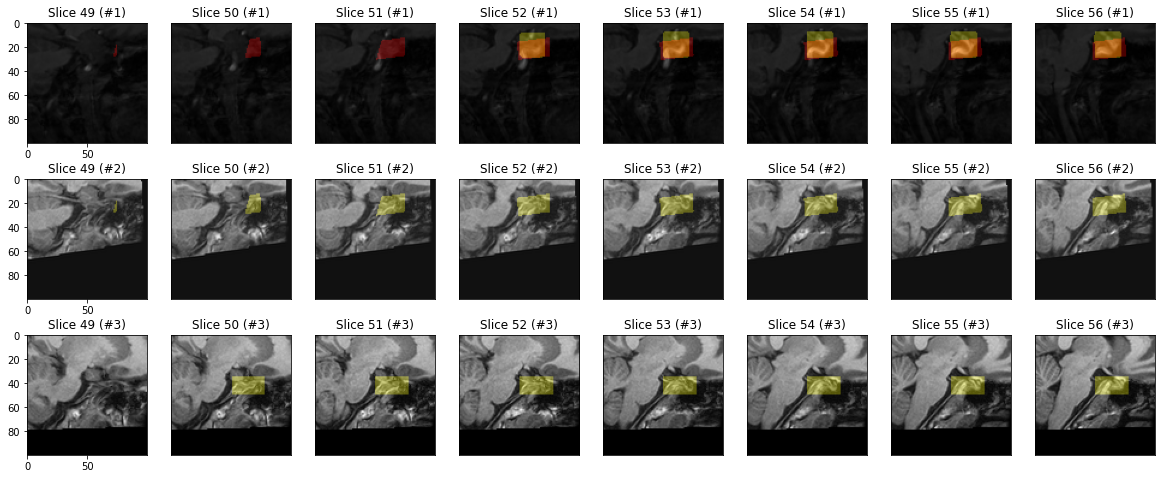

In [45]:
# Viz
cascade_pred_slice_range  = lrange(49,57)
cascade_input_slice_range = lrange(49, 57)
cascade_atlas_slice_range = lrange(49, 57)


# Row 1. Input w/ GT and Pred
# Row 2. Mapped Atlas w/ mapped atlas ROI
# Row 3. Atlas w/ Atlas ROI

viz_axis(np_arr = cascade_input_arr, \
        bin_mask_arr  = cascade_input_mask_arr, color1 = "yellow", alpha1=0.7, \
        bin_mask_arr2  = cascade_pred_mask_arr, color2 = "red", alpha2=0.7, \
        slices=cascade_input_slice_range, fixed_axis=0, \
        axis_fn = np.rot90, \
         
        np_arr_b = cascade_pred_arr, \
        bin_mask_arr_b  = cascade_pred_mask_arr, color1_b = "yellow", alpha1_b=0.3,
        slices_b = cascade_pred_slice_range,
         
        np_arr_c = cascade_atlas_arr, \
        bin_mask_arr_c  = cascade_atlas_mask_arr, color1_c = "yellow", alpha1_c=0.3,
        slices_c = cascade_atlas_slice_range,
         
        grid = [3, 8], hspace=0.3, fig_mult=2)

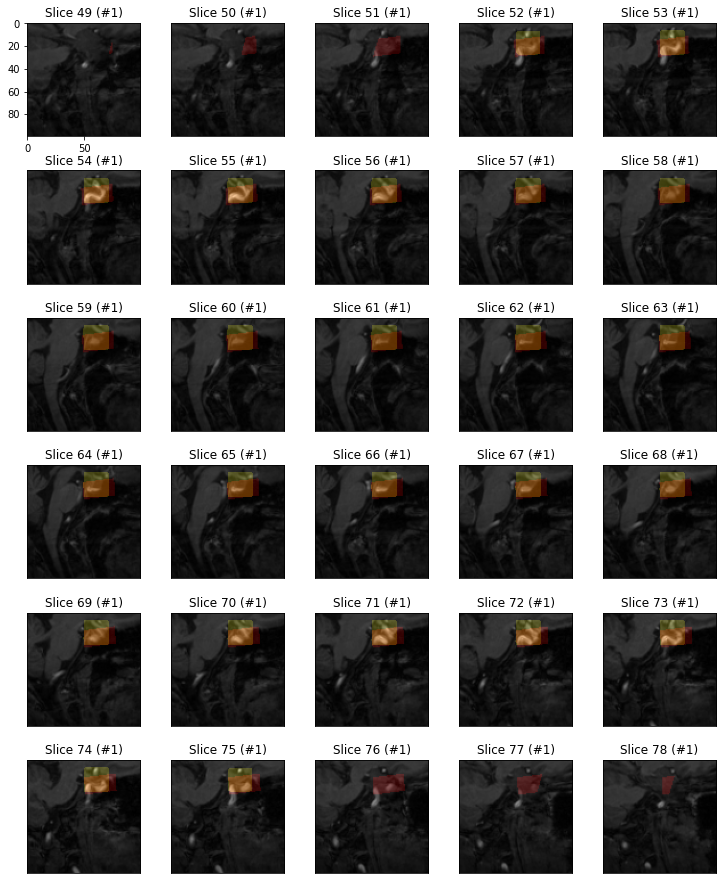

In [46]:
full_cascade_input_slice_range = lrange(49,79)
viz_axis(np_arr = cascade_input_arr, \
        bin_mask_arr  = cascade_input_mask_arr, color1 = "yellow", alpha1=0.3, \
        bin_mask_arr2  = cascade_pred_mask_arr, color2 = "red", alpha2=0.3, \
        slices=full_cascade_input_slice_range, fixed_axis=0, \
        axis_fn = np.rot90, \
        grid = [10, 5], hspace=0.3, fig_mult=2)

#### H_0 Null

Align Atlas ROI + pad to full Input


In [47]:
pads = 50,50,50

# Align Atlas ROI + pad to full Input
cascade_atlas_obj, cascade_atlas_mask_obj = get_cropped(pads, resampled_atlas_bbox_coords, resampled_atlas_obj, resampled_atlas_mask_obj)
cascade_input_obj, cascade_input_mask_obj = get_cropped(pads, pred_bbox_coords,  resampled_input_obj, resampled_input_mask_obj)

cascade_atlas_arr, cascade_atlas_mask_arr, cascade_input_arr, cascade_input_mask_arr = \
    lmap(sitk2np, (cascade_atlas_obj, cascade_atlas_mask_obj, cascade_input_obj, cascade_input_mask_obj))

cascade_atlas_bbox_coords, cascade_input_bbox_coords = lmap(mask2bbox, (cascade_atlas_mask_arr, cascade_input_mask_arr))

In [48]:
# set moving and fixed images (resample moving=>fixed using T:fixed=>moving)
fixed_obj, fixed_mask_obj   = resampled_input_obj, resampled_input_mask_obj
moving_obj, moving_mask_obj = cascade_atlas_obj, cascade_atlas_mask_obj

In [49]:
elastixImageFilter = sitk.ElastixImageFilter()
elastixImageFilter.SetFixedImage(fixed_obj)
elastixImageFilter.SetMovingImage(moving_obj)

# set parameter map
param_folder = "ElastixParamFiles"
param_files = ["affine.txt"]

parameterMapVector = sitk.VectorOfParameterMap()
for param_file in param_files:
    parameterMapVector.append(sitk.ReadParameterFile(f"{param_folder}/{param_file}"))
elastixImageFilter.SetParameterMap(parameterMapVector)

# Execute alignment
#elastixImageFilter.SetLogToConsole(False)
elastixImageFilter.Execute()

# IMPORTANT OUTPUT 1
h0_pred_obj = elastixImageFilter.GetResultImage()

# MAP MOVING (ATLAS BINARY ROI) ONTO FIXED (INPUT) 

# set moving image (atlas)                                                    
transformixImageFilter = sitk.TransformixImageFilter()
transformixImageFilter.SetMovingImage(moving_mask_obj)

# set parameter map (Binary mask => nearest neighbor final interpolation)
transformedParameterMapVector = elastixImageFilter.GetTransformParameterMap()
transformedParameterMapVector[-1]["ResampleInterpolator"] = ["FinalNearestNeighborInterpolator"]
transformixImageFilter.SetTransformParameterMap(transformedParameterMapVector)

# Execute transformation
transformixImageFilter.Execute()

# IMPORTANT OUTPUT 2
h0_pred_mask_obj = transformixImageFilter.GetResultImage()

RuntimeError: Exception thrown in SimpleITK ElastixImageFilter_Execute: /home/francesco/SimpleElastix/Code/Elastix/src/sitkElastixImageFilterImpl.cxx:259:
sitk::ERROR: 
itk::ExceptionObject (0x3715b30)
Location: "unknown" 
File: /home/francesco/SimpleElastix/build/Elastix/Core/Main/elxElastixFilter.hxx
Line: 253
Description: itk::ERROR: ElastixFilter(0x3197a00): Internal elastix error: See elastix log (use LogToConsoleOn() or LogToFileOn()).



In [ ]:
print("Input"), print_sitk_info(fixed_obj)
print("Atlas"), print_sitk_info(moving_obj)
print("Pred"), print_sitk_info(cascade_pred_obj)
print("Mask"), print_sitk_info(cascade_pred_mask_obj)

In [ ]:
cascade_pred_arr, cascade_pred_mask_arr = sitk2np(cascade_pred_obj), sitk2np(cascade_pred_mask_obj)
cascade_pred_bbox_coords = mask2bbox(cascade_pred_mask_arr)

print("Prediction: Atlas Aligned Bbox"); print_bbox(*cascade_pred_bbox_coords); print();
print("Ground Truth: Input Bbox"); print_bbox(*cascade_input_bbox_coords); print();

In [ ]:
cascade_pred_dice = compute_dice_coefficient(cascade_pred_mask_arr.astype(bool), cascade_input_mask_arr.astype(bool))
print(f"Pred dice: {cascade_pred_dice:.3f}")

In [ ]:
import matplotlib.pyplot as plt

# resample atlas onto input naively
simple_atlas_obj = sitk.Resample(resampled_atlas_obj, resampled_input_obj.GetSize(), sitk.Transform(), sitk.sitkLinear,
                         resampled_input_obj.GetOrigin(), \
                         resampled_input_obj.GetSpacing(), \
                         resampled_input_obj.GetDirection(), 0, \
                         resampled_input_obj.GetPixelID())

cimg = sitk.Cast(sitk.Compose(resampled_input_obj, 0.5*resampled_input_obj+0.5*simple_atlas_obj, simple_atlas_obj), \
                 sitk.sitkVectorUInt8)
carr = sitk2np(cimg)
plt.imshow(np.rot90(carr[85,:,:,:]))

In [ ]:
# resample atlas mask onto input naively
simple_atlas_mask_obj = sitk.Resample(resampled_atlas_mask_obj, resampled_input_obj.GetSize(), sitk.Transform(), \
                         sitk.sitkNearestNeighbor, \
                         resampled_input_obj.GetOrigin(), \
                         resampled_input_obj.GetSpacing(), \
                         resampled_input_obj.GetDirection(), 0, \
                         resampled_input_obj.GetPixelID())

simple_atlas_mask_arr = sitk2np(simple_atlas_mask_obj)
simple_atlas_bbox_coords = mask2bbox(simple_atlas_mask_arr)

print("Resampled Atlas"); print_bbox(*simple_atlas_bbox_coords); print();

In [ ]:
# Viz
simple_atlas_slice_range = lrange(73,78)

viz_axis(sitk2np(simple_atlas_obj), \
        bin_mask_arr  = simple_atlas_mask_arr, color1 = "yellow", alpha1=0.3, \
        bin_mask_arr2  = resampled_input_mask_arr, color2 = "blue", alpha2=0.7, \
        slices=resampled_atlas_slice_range, fixed_axis=0, \
        axis_fn = np.rot90, \
        grid = [1, 5], hspace=0.3, fig_mult=2)

In [ ]:
pred_dice = compute_dice_coefficient(simple_atlas_mask_arr.astype(bool), resampled_input_mask_arr.astype(bool))
print(f"Pred dice: {pred_dice:.3f}")

In [ ]:
# Viz
pred_slice_range = lrange(90,95)

viz_axis(resampled_input_mask_arr, \
        bin_mask_arr = pred_mask_arr, color1 = "blue", alpha1=0.3, \
        bin_mask_arr2  = resampled_input_mask_arr, color2 = "yellow", alpha2=0.7, \
        slices=pred_slice_range, fixed_axis=0, \
        axis_fn = np.rot90, \
        grid = [1, 5], hspace=0.3, fig_mult=2)

In [ ]:
# resample atlas onto input naively
aligned_atlas_obj = sitk.Resample(res_img, resampled_input_obj.GetSize(), sitk.Transform(), sitk.sitkLinear,
                         resampled_input_obj.GetOrigin(), \
                         resampled_input_obj.GetSpacing(), \
                         resampled_input_obj.GetDirection(), 0, \
                         resampled_input_obj.GetPixelID())

In [ ]:
cimg = sitk.Cast(sitk.Compose(resampled_input_obj, 0.5*resampled_input_obj+0.5*aligned_atlas_obj, aligned_atlas_obj), \
                 sitk.sitkVectorUInt8)
carr = sitk2np(cimg)
plt.imshow(np.rot90(carr[85,:,:,:]))

In [ ]:
# resample atlas mask onto input naively
aligned_atlas_mask_obj = sitk.Resample(pred_mask_obj, resampled_input_obj.GetSize(), sitk.Transform(), \
                         sitk.sitkNearestNeighbor, \
                         resampled_input_obj.GetOrigin(), \
                         resampled_input_obj.GetSpacing(), \
                         resampled_input_obj.GetDirection(), 0, \
                         resampled_input_obj.GetPixelID())

aligned_atlas_mask_arr = sitk2np(aligned_atlas_mask_obj)
aligned_atlas_bbox_coords = mask2bbox(aligned_atlas_mask_arr)

print("Aligned Resampled Atlas"); print_bbox(*aligned_atlas_bbox_coords); print();

In [ ]:
pred_dice = compute_dice_coefficient(aligned_atlas_mask_arr.astype(bool), resampled_input_mask_arr.astype(bool))
print(f"Pred dice: {pred_dice:.3f}")

In [ ]:
# Viz
index = 0
slice_range = lrange(80,85)

viz_axis(cimg, \
#         bin_mask_arr  = input_mask_arrs[index], color1 = "yellow", alpha1=0.3, \
#         bin_mask_arr2 = atlas_mask_arrs[index], color2 = "blue", alpha2=0.3,
        slices=slice_range, fixed_axis=0, \
        axis_fn = np.rot90, \
        grid = [1, 5], hspace=0.3, fig_mult=2)

In [ ]:
im
plt.imshow(sitk.GetArrayViewFromImage(cimg))

In [ ]:
simg1 = moving_obj
simg2 = fixed_obj
cimg = sitk.Compose(simg1, simg2, simg1 // 2. + simg2 // 2.)

In [ ]:
simg1 = res_img
simg2 = fixed_obj
cimg = sitk.Compose(simg1, simg2, simg1 // 2. + simg2 // 2.)

In [ ]:
#selx.SetLogToConsole(False)

def align(fixed_obj, moving_obj, param_folder = "ElastixParamFiles", param_files = ["affine.txt"]):
    
    # ALIGN ATLAS AND INPUT IMAGE
    
    # set moving and fixed images (resample moving=>fixed using T:fixed=>moving)
    elastixImageFilter = sitk.ElastixImageFilter()
    elastixImageFilter.SetFixedImage(fixed_obj)
    elastixImageFilter.SetMovingImage(moving_obj)
    
    # set parameter map
    parameterMapVector = sitk.VectorOfParameterMap()
    for param_file in param_files:
        parameterMapVector.append(sitk.ReadParameterFile(f"{param_folder}/{param_file}"))
    elastixImageFilter.SetParameterMap(parameterMapVector)

    # Execute alignment
    #elastixImageFilter.SetLogToConsole(False)
    elastixImageFilter.Execute()

    # MAP MOVING (ATLAS BINARY ROI) ONTO FIXED (INPUT) 

    # set moving image (atlas)                                                    
    transformixImageFilter = sitk.TransformixImageFilter()
    transformixImageFilter.SetMovingImage(moving_mask_obj)
                    
    # set parameter map (Binary mask => nearest neighbor final interpolation)
    transformedParameterMapVector = elastixImageFilter.GetTransformParameterMap()
    transformedParameterMapVector[-1]["ResampleInterpolator"] = ["FinalNearestNeighborInterpolator"]
    transformixImageFilter.SetTransformParameterMap(transformedParameterMapVector)

    # Execute transformation
    #transformixImageFilter.SetLogToConsole(False)
    transformixImageFilter.Execute()
    
    return transformixImageFilter.GetResultImage()

# Elastix Registration

## Rigid Alignment

- Rigid: "rigid body, which can translate and rotate, but cannot be
scaled/stretched."

- Similarity: "translate, rotate, and scale isotropically."

- Affine: "translated, rotated, scaled,
and sheared."

### ROI Mapping
Elastix convention: Resampling $moving \to fixed$ image involves a transformation $T: fixed \to moving$. $T$ maps coordinates in the fixed image domain to the corresponding coordinates in the moving image. Resampling a moving image onto the fixed image coordinate system involves:
1. Apply $T$ to fixed image voxel coordinates $x$ to get corresponding coordinates $y$ in the moving domain: $y = T(x) \in I_M$.
2. Estimate the voxel intensities $v$ at the moving image coordinates $y \in I_m$ via (linear) interpolation from nearby moving image voxel intensities.
3. Set the voxel intensities $v$ at the fixed image coordinates $x \in I_F$ to the above moving image voxel intensities.

Source: 5.0.1 Elastix Manual

In [ ]:
#selx.SetLogToConsole(False)

def align_and_tfm(fixed_obj, moving_obj, moving_mask_obj, \
                  param_folder = "ElastixParamFiles", param_files = ["affine.txt", "bspline.txt"]):
    
    # ALIGN ATLAS AND INPUT IMAGE
    
    # set moving and fixed images (resample moving=>fixed using T:fixed=>moving)
    elastixImageFilter = sitk.ElastixImageFilter()
    elastixImageFilter.SetFixedImage(fixed_obj)
    elastixImageFilter.SetMovingImage(moving_obj)
    
    # set parameter map
    parameterMapVector = sitk.VectorOfParameterMap()
    for param_file in param_files:
        parameterMapVector.append(sitk.ReadParameterFile(f"{param_folder}/{param_file}"))
    elastixImageFilter.SetParameterMap(parameterMapVector)

    # Execute alignment
    #elastixImageFilter.SetLogToConsole(False)
    elastixImageFilter.Execute()

    # MAP MOVING (ATLAS BINARY ROI) ONTO FIXED (INPUT) 

    # set moving image (atlas)                                                    
    transformixImageFilter = sitk.TransformixImageFilter()
    transformixImageFilter.SetMovingImage(moving_mask_obj)
                    
    # set parameter map (Binary mask => nearest neighbor final interpolation)
    transformedParameterMapVector = elastixImageFilter.GetTransformParameterMap()
    transformedParameterMapVector[-1]["ResampleInterpolator"] = ["FinalNearestNeighborInterpolator"]
    transformixImageFilter.SetTransformParameterMap(transformedParameterMapVector)

    # Execute transformation
    #transformixImageFilter.SetLogToConsole(False)
    transformixImageFilter.Execute()
    
    return transformixImageFilter.GetResultImage()

# Rigid only

In [ ]:
import time

def get_dice_scores(input_obj, input_mask_arr, atlas_objs = atlas_objs, atlas_mask_objs = atlas_mask_objs):
    dice_scores = {}
    n_votes = len(atlas_objs)
    print(f"N={n_votes} atlases in the vote.")
    
    for i in range(n_votes):
        print(f"Getting pred for atlas {i}:")
        
        start = time.time()
        pred_mask_arr = sitk2np(align_and_tfm(input_obj, atlas_objs[i], atlas_mask_objs[i], \
                                              param_files = ["affine.txt"])).astype(bool)
        end = time.time()
        print(f"{end - start:.0f} sec.")
        # compute dice
        dice_scores[f"dice{i}"] = compute_dice_coefficient(input_mask_arr, pred_mask_arr)
    
        # add atlas vote
        if i == 0: vote_pred_mask_arr = pred_mask_arr.astype(np.uint8)
        else: vote_pred_mask_arr += pred_mask_arr.astype(np.uint8)
    
    # get avg dice score
    dice_scores[f"dice_avg"] = np.mean(list(dice_scores.values()))
    
    # get vote
    print(f"Getting vote dice")
    vote_pred_mask_arr = (vote_pred_mask_arr >= n_votes/2).astype(bool)
    dice_scores[f"dice_vote_all"] = compute_dice_coefficient(input_mask_arr, vote_pred_mask_arr)
    
    print(dice_scores)
    return dice_scores

In [ ]:
dice_scores0 = get_dice_scores(input_objs[0], input_mask_arrs[0], atlas_objs[:2], atlas_mask_objs[:2])

In [ ]:
dice_scores0

In [ ]:
dice_scores0 = get_dice_scores(input_objs[0], input_mask_arrs[0], atlas_objs, atlas_mask_objs)

In [ ]:
dice_scores0

In [ ]:
input_df = DataFrame(get_dice_scores(input_obj, gt_mask, atlas_objs, atlas_mask_objs) \
                     for input_obj, gt_mask in zip(input_objs, input_mask_arrs))

In [ ]:
input_df

In [ ]:
input_info_df

In [ ]:
atlas_info_df

In [ ]:
# Viz
index = 5
slice_range = lrange(110,130)

viz_axis(sitk2np(atlas_objs[index]), \
        bin_mask_arr = atlas_mask_arrs[index], color1 = "yellow", alpha1=0.3,
        slices=slice_range, fixed_axis=2, \
        axis_fn = np.rot90, \
        grid = [4,5], hspace=0.3, fig_mult=2)

In [ ]:
# Viz
index = 10
slice_range = lrange(80,100)

viz_axis(sitk2np(input_objs[index]), \
        bin_mask_arr = input_mask_arrs[index], color1 = "yellow", alpha1=0.3,
        slices=slice_range, fixed_axis=0, \
        axis_fn = np.rot90, \
        grid = [4, 5], hspace=0.3, fig_mult=2)

In [ ]:
# Viz
index = 12
slice_range = lrange(80,90)

viz_axis(sitk2np(input_objs[index]), \
        bin_mask_arr = input_mask_arrs[index], color1 = "yellow", alpha1=0.3,
        slices=slice_range, fixed_axis=0, \
        axis_fn = np.rot90, \
        grid = [2, 5], hspace=0.3, fig_mult=2)

In [ ]:
# Align the atlas and the input MR. Resample atlas ROI onto input ROI (fixed: input, moving: atlas). 
pred_mask_objs = [align_and_tfm(input_obj, atlas_obj, atlas_mask_obj, \
                              param_folder = "ElastixParamFiles", param_files = ["affine.txt"]) for
                 atlas_obj, atlas_mask_obj in zip(atlas_objs, atlas_mask_objs)]

In [ ]:
# Evaluate predicted input ROI
gt_mask_arr = input_mask_arr

#gt_mask_arr   = sitk2np(gt_mask_obj).astype(bool)
pred_mask_arr = sitk2np(pred_mask_obj).astype(bool)

In [ ]:
dice     = compute_dice_coefficient(gt_mask_arr, pred_mask_arr)
coverage = compute_coverage_coefficient(gt_mask_arr, pred_mask_arr)
bbox_coords = mask2bbox(pred_mask_arr)

In [ ]:
print({"dice": f"{dice:0.2f}", "coverage": f"{coverage:0.2f}"})
print_bbox(*bbox_coords)

In [ ]:
print("Affine: ", bbox_coords)
print("GT: ", input_bbox_coords)

In [ ]:
# Viz affine
slice_range = lrange(77, 82) + lrange(107,112)

viz_axis(sitk2np(input_obj), cmap0="gray",
        crop_coords = bbox_coords, crop_extra=35,
        bin_mask_arr = input_mask_arr, color1 = "yellow", alpha1=0.3,
        bin_mask_arr2 = pred_mask_arr, color2 = "red", alpha2=0.3,
        slices=slice_range, fixed_axis=0, \
        axis_fn = np.rot90, \
        grid = [2, 4], hspace=0.3, fig_mult=2)

In [ ]:
slice_range = lrange(110, 150)
viz_axis(sitk2np(input_obj), cmap0="gray",
        crop_coords = bbox_coords, crop_extra=20,
        bin_mask_arr = input_mask_arr, color1 = "yellow", alpha1=0.3,
        bin_mask_arr2 = pred_mask_arr, color2 = "red", alpha2=0.3,
        slices=slice_range, fixed_axis=1, \
        axis_fn = np.rot90, \
        grid = [5, 8], hspace=0.3, fig_mult=2)

In [ ]:
# Align the atlas and the input MR. Resample atlas ROI onto input ROI (fixed: input, moving: atlas). 
bspline_pred_mask_obj = align_and_tfm(input_obj, atlas_obj, atlas_mask_obj, \
                              param_folder = "ElastixParamFiles", param_files = ["affine.txt", "bspline.txt"])

In [ ]:
# Evaluate predicted input ROI
bspline_pred_mask_arr = sitk2np(bspline_pred_mask_obj).astype(bool)

bspline_dice     = compute_dice_coefficient(gt_mask_arr, bspline_pred_mask_arr)
bspline_coverage = compute_coverage_coefficient(gt_mask_arr, bspline_pred_mask_arr)
bspline_bbox_coords = mask2bbox(bspline_pred_mask_arr)

print({"dice": f"{bspline_dice:0.2f}", "coverage": f"{bspline_coverage:0.2f}"})
print_bbox(*bspline_bbox_coords)

In [ ]:
print("Affine: ", bbox_coords)
print("+Bspline: ", bspline_bbox_coords)
print("GT: ", input_bbox_coords)

In [ ]:
print("Ground Truth GT")
print_bbox(*input_bbox_coords)

print("Affine only")
print_bbox(*bbox_coords)

print("+Bspline")
print_bbox(*bspline_bbox_coords)

In [ ]:
# Viz affine + bspline
slice_range = lrange(77, 82) + lrange(107,112)

viz_axis(sitk2np(input_obj), cmap0="gray",
        crop_coords = bspline_bbox_coords, crop_extra=35,
        bin_mask_arr = input_mask_arr, color1 = "yellow", alpha1=0.3,
        bin_mask_arr2 = bspline_pred_mask_arr, color2 = "red", alpha2=0.3,
        slices=slice_range, fixed_axis=0, \
        axis_fn = np.rot90, \
        grid = [2, 5], hspace=0.3, fig_mult=2)

In [ ]:
slice_range = lrange(110, 150)
viz_axis(sitk2np(input_obj), cmap0="gray",
        crop_coords = bbox_coords, crop_extra=20,
        bin_mask_arr = input_mask_arr, color1 = "yellow", alpha1=0.3,
        bin_mask_arr2 = bspline_pred_mask_arr, color2 = "red", alpha2=0.3,
        slices=slice_range, fixed_axis=1, \
        axis_fn = np.rot90, \
        grid = [5, 8], hspace=0.3, fig_mult=2)

In [ ]:
slice_range = [77,78,79, 80] + [109,110,111,112]

viz_axis(sitk2np(input_obj), cmap0="gray",
        crop_coords = bspline_bbox_coords, crop_extra=55,
        bin_mask_arr = input_mask_arr, color1 = "yellow", alpha1=0.3,
        bin_mask_arr2 = bspline_pred_mask_arr, color2 = "red", alpha2=0.3,
        slices=slice_range, fixed_axis=0, \
        axis_fn = np.rot90, \
        grid = [2, 4], hspace=0.3, fig_mult=2)

# Affine non-whole brain

Focus alignment on generated input ROI

In [ ]:
# pad slices by 5, crop extra bbox by 10vox x 10vox

In [ ]:
def crop_extra_mask(bin_mask_arr, crop_coords, slice_pad, vox_pad, fixed_axis=06):
    imin, imax, jmin, jmax, kmin, kmax = crop_coords
    if fixed_axis == 0:   
        jmin -= pad; jmax += pad; kmin -= pad; kmax += pad;
        np_arr = np_arr[:, jmin:jmax, kmin:kmax]
        if bin_mask_arr is not None:  bin_mask_arr  = bin_mask_arr[:, jmin:jmax, kmin:kmax]
        if bin_mask_arr2 is not None: bin_mask_arr2 = bin_mask_arr2[:, jmin:jmax, kmin:kmax]

    elif fixed_axis == 1: 
        imin -= pad; imax += pad; kmin -= pad; kmax += pad;
        np_arr = np_arr[imin:imax, :, kmin:kmax]
        if bin_mask_arr is not None:  bin_mask_arr  = bin_mask_arr[imin:imax, :, kmin:kmax]
        if bin_mask_arr2 is not None: bin_mask_arr2 = bin_mask_arr2[imin:imax, :, kmin:kmax]

    else:
        imin -= pad; imax += pad; jmin -= pad; jmax += pad;
        np_arr = np_arr[imin:imax, jmin:jmax, :]
        if bin_mask_arr is not None:  bin_mask_arr  = bin_mask_arr[imin:imax, jmin:jmax, :]
        if bin_mask_arr2 is not None: bin_mask_arr2 = bin_mask_arr2[imin:imax, jmin:jmax, :]

In [ ]:
pred_mask_obj

In [ ]:
# Align the atlas and the input MR. Resample atlas ROI onto input ROI (fixed: input, moving: atlas). 
pred_mask_obj = align_focused(input_obj, pred_roi, atlas_obj, atlas_mask_obj, \
                              param_folder = "ElastixParamFiles", param_files = ["affine.txt"])

In [ ]:
def align_focused(fixed_obj, fixed_mask_obj, moving_obj, moving_mask_obj, \
                  param_folder = "ElastixParamFiles", param_files = ["affine.txt", "bspline.txt"]):
    
    # ALIGN ATLAS AND INPUT IMAGE
    
    # set moving and fixed images (resample moving=>fixed using T:fixed=>moving)
    elastixImageFilter = sitk.ElastixImageFilter()
    elastixImageFilter.SetFixedImage(fixed_obj)
    elastixImageFilter.SetMovingImage(moving_obj)
    
    # set masks
    elastixImageFilter.SetFixedMask(fixed_mask_obj)
    elastixImageFilter.SetMovingMask(moving_mask_obj)
    
    
    # set parameter map
    parameterMapVector = sitk.VectorOfParameterMap()
    for param_file in param_files:
        parameterMapVector.append(sitk.ReadParameterFile(f"{param_folder}/{param_file}"))
    elastixImageFilter.SetParameterMap(parameterMapVector)

    # Execute alignment
    elastixImageFilter.Execute()

    # MAP MOVING (ATLAS BINARY ROI) ONTO FIXED (INPUT) 

    # set moving image (atlas)                                                    
    transformixImageFilter = sitk.TransformixImageFilter()
    transformixImageFilter.SetMovingImage(moving_mask_obj)
                    
    # set parameter map (Binary mask => nearest neighbor final interpolation)
    transformedParameterMapVector = elastixImageFilter.GetTransformParameterMap()
    transformedParameterMapVector[-1]["ResampleInterpolator"] = ["FinalNearestNeighborInterpolator"]
    transformixImageFilter.SetTransformParameterMap(transformedParameterMapVector)

    # Execute transformation
    transformixImageFilter.Execute()
    
    return transformixImageFilter.GetResultImage()

### Viz Mapped ROI

In [ ]:
print(transformed_input_mask_arr.shape)

transformed_input_bbox_coords = mask2bbox(transformed_input_mask_arr)
print_bbox(*transformed_input_bbox_coords)

Compare bounding boxes

In [ ]:
print(f"Original Moving Mask"), print_bbox(*input_bbox_coords);
print(f"ROI contains {np.count_nonzero(input_mask_arr)} elements.", "\n");

print(f"Target Fixed Mask"), print_bbox(*atlas_bbox_coords);
print(f"ROI contains {np.count_nonzero(atlas_mask_arr)} elements.", "\n");

print(f"Transformed Moving Mask"), print_bbox(*transformed_input_bbox_coords);
print(f"ROI contains {np.count_nonzero(transformed_input_mask_arr)} elements.", "\n");

In [ ]:
viz_axis(input_mask_arr, bin_mask_arr=transformed_input_mask_arr, 
        slices=lrange(76, 80) + lrange(110,112), atlas_axis=0, \
        axis_fn = np.rot90, \
        grid = [2, 3], hspace=0.3, fig_mult=2, cmap0="gray")

### Coronal

In [ ]:
sitk2np(iso_atlas_obj).shape

In [ ]:
viz_axis(sitk2np(atlas_obj), \
        bin_mask_arr=transformed_input_mask_arr, color1 = "yellow", \
        bin_mask_arr2=atlas_mask_arr, color2 = "red", \
        slices=lrange(120, 126), atlas_axis=1, \
        axis_fn = np.rot90, \
        grid = [2, 3], hspace=0.3, fig_mult=2, cmap0="gray")

## Sagittal

In [ ]:
#cmap1 = [white, yellow]; cmap2 = [white, blue]
viz_axis(sitk2np(atlas_obj), \
        bin_mask_arr=transformed_input_mask_arr, color1 = "yellow", \
        bin_mask_arr2=atlas_mask_arr, color2 = "red", \
        slices=lrange(76, 80) + lrange(104,112), atlas_axis=0, \
        axis_fn = np.rot90, \
        grid = [3, 4], hspace=0.3, fig_mult=2, cmap0="gray")

# Old

In [ ]:
def affine_align(fixed_obj, fixed_mask_obj, moving_obj, moving_mask_obj, param_file = "AffineParamFile.txt"):
    
    # map moving => fixed (the transform is fixed => moving)
    #parameterMap = sitk.GetDefaultParameterMap('affine')
    parameterMap  = sitk.ReadParameterFile(param_file)
    
    elastixImageFilter = sitk.ElastixImageFilter()
    elastixImageFilter.SetFixedImage(fixed_obj)
    elastixImageFilter.SetMovingImage(moving_obj)
    
    # focus on registering moving mask ROI
    #elastixImageFilter.SetMovingMask(moving_mask_obj)
    #parameterMap["ImageSampler"] = ["RandomSparseMask"]
   
    # print param map
    sitk.PrintParameterMap(parameterMap)
    
    elastixImageFilter.SetParameterMap(parameterMap)
    elastixImageFilter.Execute()

    transformed_moving_obj  = elastixImageFilter.GetResultImage()
    transformedParameterMap = elastixImageFilter.GetTransformParameterMap()[0]
    
    # Binary mask => nearest neighbor
    transformedParameterMap["ResampleInterpolator"] = ["FinalNearestNeighborInterpolator"]
    
    # map ROI of moving => fixed
    transformixImageFilter = sitk.TransformixImageFilter()
    transformixImageFilter.SetTransformParameterMap(transformedParameterMap)
    transformixImageFilter.SetMovingImage(moving_mask_obj)
    transformixImageFilter.Execute()
    
    transformed_moving_mask_obj = transformixImageFilter.GetResultImage()

    # evaluate: dice, coverage
    fixed_mask_arr              = sitk2np(fixed_mask_obj).astype(bool)
    transformed_moving_mask_arr = sitk2np(transformed_moving_mask_obj).astype(bool)

    dice     = compute_dice_coefficient(fixed_mask_arr, transformed_moving_mask_arr)
    coverage = compute_coverage_coefficient(fixed_mask_arr, transformed_moving_mask_arr)
    
    # save bounding box coords
    bbox_coords = mask2bbox(transformed_moving_mask_arr)
        
    return dice, coverage, bbox_coords, transformed_moving_obj, transformed_moving_mask_arr

In [ ]:
dice, coverage, bbox_coords, transformed_input_obj, transformed_input_mask_arr = affine_align(atlas_obj, atlas_mask_obj, input_obj, input_mask_obj)

In [ ]:
print(f"Dice: {dice}. Coverage {coverage}.")
print_bbox(*bbox_coords)